In [2]:
#@python 3.8.10
#@author moon ying
#plot continuum membrane results with matplotlib 3d plot and trimesh package
#dependencies are listed as follows

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import trimesh as tr
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import seaborn as sns
sns.set_context("talk")

In [3]:
# INPUT
infile = "vertex47.csv" # the input vertex file
num_gags = "588"
gag_infile_id = "1200" # "X" in "SplineX.csv"
z_axis_shift = 50 # recover z-axis shift in model to put z(membrane) @z=0
pdb_name = "~/results/GagR50ComplexPDB/GagR50_588.pdb" #pdb file name

In [4]:
# vertices as pandas.DataFrame
vertices = pd.read_csv(infile, header = None)
vertices.columns = ["x","y","z"]
vertices["z"]-= z_axis_shift
vertices

,x,y,z
0,-89.1774,-90.4678,0.0
1,-87.3652,-90.4608,0.0
2,-85.5527,-90.4529,0.0
3,-83.7399,-90.4440,0.0
4,-81.9266,-90.4337,0.0
...,...,...,...
11812,83.7000,90.4131,0.0
11813,85.5000,90.4131,0.0
11814,87.3000,90.4131,0.0
11815,89.1000,90.4131,0.0


In [5]:
# gags as pandas.DataFrame
gags = pd.read_csv("Spline" + gag_infile_id + ".csv", header=None)
gags.columns = ["x", "y", "z"]
gags["z"]-= z_axis_shift
gags

,x,y,z
0,-0.090164,6.458110,13.6406
1,0.327321,0.407154,14.0535
2,2.744450,-0.536183,13.9811
3,4.766350,1.084330,13.8232
4,-0.265906,-2.357700,13.9966
...,...,...,...
583,38.698000,-8.220790,-5.2863
584,33.184400,23.947900,-7.1029
585,34.855400,-14.117600,-2.9319
586,10.295400,-26.292500,5.3147


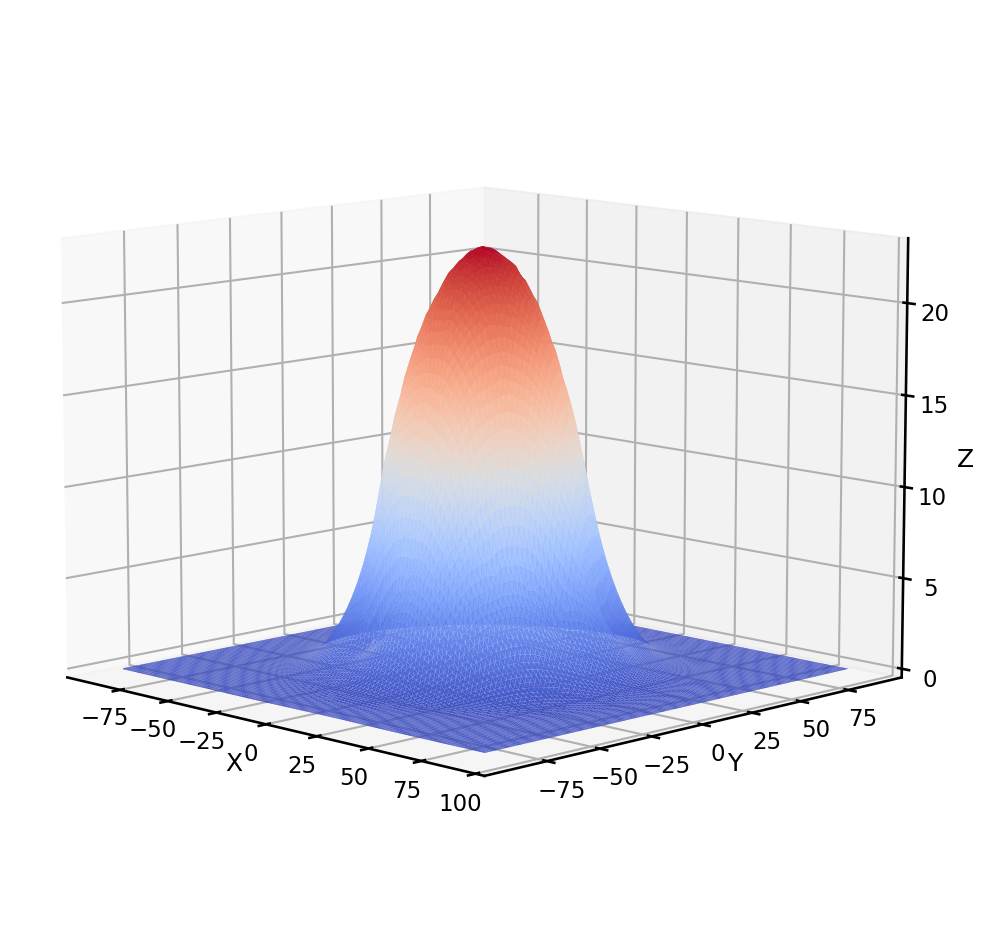

In [6]:
# Simple plot of membrane only
# Z-axis not drawn to scale
# this is for quick checking deformation of the membrane

fig = plt.figure(figsize=(24, 12))
ax = plt.axes(projection='3d')

# Plot the surface.

# uncomment the following line for scatter representation
# ax.scatter3D(vertices["x"], vertices["y"], vertices["z"], c = vertices["z"], s = 16.0);
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# uncomment the following line for triangular surface representation
surf = ax.plot_trisurf(vertices["x"], vertices["y"], vertices["z"], cmap=cm.coolwarm)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(elev = 10, azim = -45)
plt.savefig(num_gags + "gags_SurfaceOverview", dpi = 900)

In [7]:
# %%
def read_pdb(filename):
    """
    Read .pdb file from NERDSS output for gag lattices
    and return dataframe with header renamed. Note the
    last two columns are only placeholder for pdb file
    format.

    Args:
        filename (str): file name string

    Returns:
        df (pandas.DataFrame): dataframe of imported pdb
    """
    df = pd.read_csv(filename, skiprows = 3, sep = "\s+", header = None) #"\s+" for undefined number of spaces
    df.columns = ["Type", "Index", "Particle", "Molecule", "Molecule Index", "X", "Y", "Z", "Occupancy", "Atom"]
    return df

# %%
def get_COM_coord(df, drop = True):
    """
    Extract coordinate data (XYZ) of COM from the input
    dataframe based on "Particle" property. .

    Args:
        df (pandas.DataFrame): dataframe of imported pdb
        drop (bool, optional): Drop all other properties 
        except for CoM coordinates when set to drop = True.
        Defaults to True.

    Returns:
        df_COM (pandas.DataFrame): dataframe of imported pdb
        with only CoM coordinate data.
    """
    df_COM = df.loc[df['Particle'] == "COM"].reset_index(drop = True)
    if drop:
        df_COM = df_COM.drop(columns =\
                             ["Type", "Particle", "Index", "Molecule", "Molecule Index", "Occupancy", "Atom"])
    return df_COM

#%%
def is_shorter_than(arraylike1, arraylike2, dist_cutoff):
    """
    Determine if the distance between arraylike1 and arraylike2
    is shorter than dist_cutoff.

    Returns:
        boolean: True if ||arraylike1 arraylike2|| < dist_cutoff
    """
    if ((arraylike1[0] - arraylike2[0]) ** 2 + (arraylike1[1] - arraylike2[1]) ** 2 +\
            (arraylike1[2] - arraylike2[2]) ** 2 < dist_cutoff ** 2):
        return True
    else:
        return False

In [8]:
# This part serves to plot gags as sticks
# the intermolecular and intramolecular bonds are plotted differentially

df = read_pdb(pdb_name)

df_COM = get_COM_coord(df)
COM_COM = np.array([df_COM["X"].mean(), df_COM["Y"].mean(), df_COM["Z"].mean()])
df_gags_r = gags.copy()
df_gags_r.columns = ["X","Y","Z"]
COM_gags_r = np.array([df_gags_r["X"].mean(), df_gags_r["Y"].mean(), df_gags_r["Z"].mean()])

#zero COM for both rotated and unrotated
#unrotated->
df = read_pdb(pdb_name)
df["X"] -= COM_COM[0]
df["Y"] -= COM_COM[1]
df["Z"] -= COM_COM[2]

#rotated->
df_gags_r = gags.copy()
df_gags_r.columns = ["X","Y","Z"]
df_gags_r["X"] -= COM_gags_r[0]
df_gags_r["Y"] -= COM_gags_r[1]
df_gags_r["Z"] -= COM_gags_r[2]

#COM
df_COM = get_COM_coord(df)
df_COM


#https://math.stackexchange.com/questions/158538/3d-transformation-two-triangles
#rotate df_COM to gags_r
gags_r_np = df_gags_r.to_numpy()
df_COM_np = df_COM.to_numpy()
rlist = []

for i in range(1, 2):
    j = i * 3

    cbar = gags_r_np[j:j+3].mean(axis = 0)
    c = df_COM_np[j:j+3].mean(axis = 0)
    ybar = gags_r_np[j:j+3] - cbar
    y = df_COM_np[j:j+3] - c
    H = np.outer(y[0], ybar[0]) + np.outer(y[1], ybar[1]) + np.outer(y[2], ybar[2])
    s, v, d = np.linalg.svd(H)
    R = np.matmul(np.transpose(d), np.transpose(s))
    print(R)
    print(cbar - np.matmul(R, c))
    rlist.append(R)
    

rmat = sum(rlist)/len(rlist)
df[["X","Y","Z"]] = np.transpose(np.matmul(rmat, np.transpose(df[["X","Y","Z"]].to_numpy())))
#recover displacement
df["X"] += COM_gags_r[0]
df["Y"] += COM_gags_r[1]
df["Z"] += COM_gags_r[2]
df.to_csv(num_gags + "full_gags.csv")
df_full_gags = df
df_full_gags_np = df_full_gags[["X","Y","Z"]].to_numpy()

#%
nearbypt_pairlist = []
for i in range(0, int(len(df_full_gags))):
    for j in range(0, i):
        if (is_shorter_than(df_full_gags_np[i], df_full_gags_np[j], 0.9)):
            nearbypt_pairlist.append((i,j))
            #print(f"({i},{j})")


[[ 0.40843431 -0.60161296 -0.6864716 ]
 [-0.61546893  0.37387041 -0.69384358]
 [ 0.67407671  0.70589146 -0.21757258]]
[-8.40923853e-05  1.11106508e-04  4.57093871e-06]


In [9]:
df_full_gags

,Type,Index,Particle,Molecule,Molecule Index,X,Y,Z,Occupancy,Atom
0,ATOM,1,COM,A,0,-0.090079,6.458005,13.640673,0,0CL
1,ATOM,2,b,A,0,0.931678,5.644474,12.882564,0,0CL
2,ATOM,3,c,A,0,-0.286183,5.068444,14.604754,0,0CL
3,ATOM,4,d,A,0,0.595979,7.217128,11.909426,0,0CL
4,ATOM,5,p,A,0,-0.390535,6.981996,11.915672,0,0CL
...,...,...,...,...,...,...,...,...,...,...
3523,ATOM,3536,b,A,589,-28.109896,-10.115407,3.028876,0,0CL
3524,ATOM,3537,c,A,589,-30.179954,-9.802046,3.661366,0,0CL
3525,ATOM,3538,d,A,589,-26.773460,-8.828417,3.330408,0,0CL
3526,ATOM,3539,p,A,589,-27.417045,-8.117432,3.001739,0,0CL


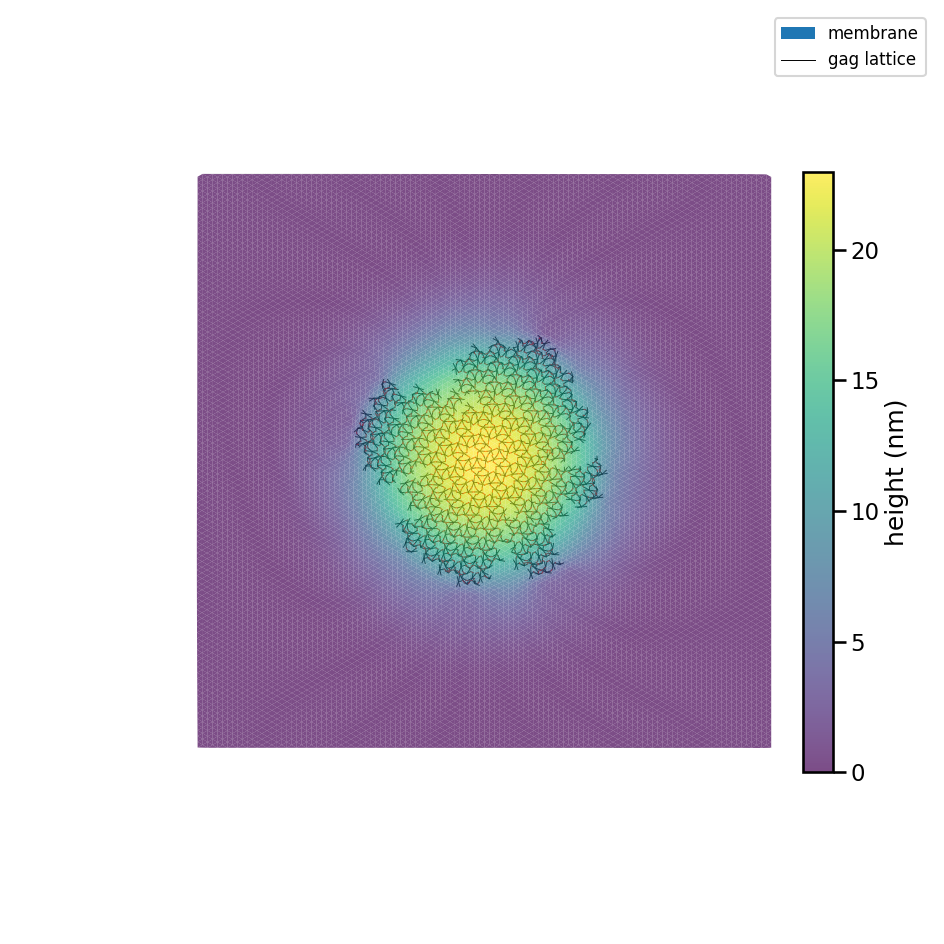

In [10]:
# Plot the surface.

#%
fig = plt.figure(figsize=(24, 12))
ax = plt.axes(projection='3d')

#surf_gags = ax.plot_trisurf(gags["x"], gags["y"], gags["z"], cmap="Oranges")
surf_vertices = ax.plot_trisurf(vertices["x"], vertices["y"], vertices["z"], \
                                cmap="viridis", alpha = 0.7, label = "membrane")
# https://stackoverflow.com/questions/54994600/pyplot-legend-poly3dcollection-object-has-no-attribute-edgecolors2d
surf_vertices._facecolors2d=surf_vertices._facecolors
surf_vertices._edgecolors2d=surf_vertices._edgecolors

plt.colorbar(surf_vertices, shrink = 0.65, pad = 0.01, anchor = (-0.6, 0.5), label = "height (nm)")


for i in range(0, int(len(df_full_gags)/6)):
    for j in range(1, 6):
        if (i == 0 and j == 1):
            ax.plot([df_full_gags["X"][6 * i], df_full_gags["X"][6 * i + j]],\
                [df_full_gags["Y"][6 * i], df_full_gags["Y"][6 * i + j]],\
                [df_full_gags["Z"][6 * i], df_full_gags["Z"][6 * i + j]], "k", linewidth = 0.7, label = "gag lattice")
        else:
            ax.plot([df_full_gags["X"][6 * i], df_full_gags["X"][6 * i + j]],\
                [df_full_gags["Y"][6 * i], df_full_gags["Y"][6 * i + j]],\
                [df_full_gags["Z"][6 * i], df_full_gags["Z"][6 * i + j]], "k", linewidth = 0.7)
for (i, j) in nearbypt_pairlist:
    ax.plot([df_full_gags_np[i][0], df_full_gags_np[j][0]],\
                [df_full_gags_np[i][1], df_full_gags_np[j][1]],\
                [df_full_gags_np[i][2], df_full_gags_np[j][2]], "r", linewidth = 0.7)
#ax.set_xlabel('X')
#ax.set_ylabel('Y')
#ax.set_zlabel('Z')


ax.set_xlim3d(-90.0, 90.0)
ax.set_ylim3d(-90.0, 90.0)
ax.set_zlim3d(-100.0, 100.0)
ax.set_axis_off()
ax.legend(prop={'size': 12})
ax.view_init(elev = 90, azim = 0)

plt.savefig(num_gags + "gags_stick_membrane_topdown_uniform_zscale.png", dpi = 900)

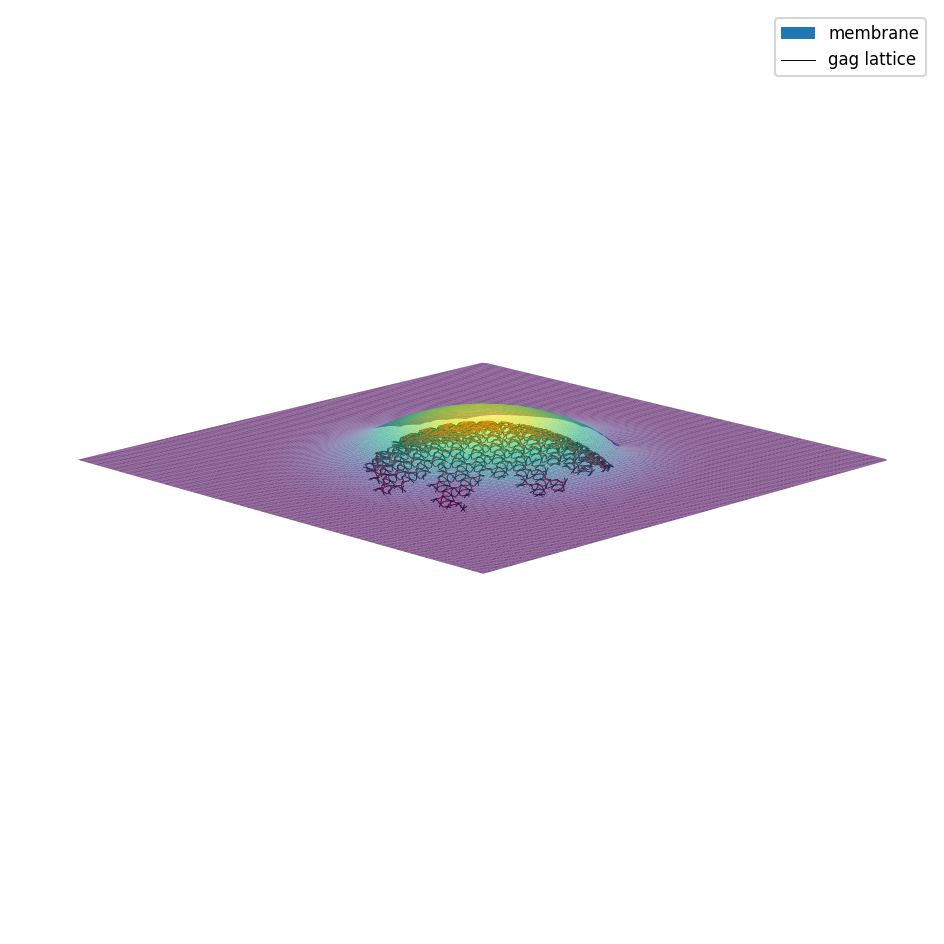

In [11]:
# Plot the surface.

#%
fig = plt.figure(figsize=(24, 12))
ax = plt.axes(projection='3d')

#surf_gags = ax.plot_trisurf(gags["x"], gags["y"], gags["z"], cmap="Oranges")
surf_vertices = ax.plot_trisurf(vertices["x"], vertices["y"], vertices["z"], \
                                cmap="viridis", alpha = 0.7, label = "membrane")
# https://stackoverflow.com/questions/54994600/pyplot-legend-poly3dcollection-object-has-no-attribute-edgecolors2d
surf_vertices._facecolors2d=surf_vertices._facecolors
surf_vertices._edgecolors2d=surf_vertices._edgecolors

#plt.colorbar(surf_vertices, shrink = 0.65, pad = 0.01, anchor = (-0.0, 0.5), label = "height (nm)")


for i in range(0, int(len(df_full_gags)/6)):
    for j in range(1, 6):
        if (i == 0 and j == 1):
            ax.plot([df_full_gags["X"][6 * i], df_full_gags["X"][6 * i + j]],\
                [df_full_gags["Y"][6 * i], df_full_gags["Y"][6 * i + j]],\
                [df_full_gags["Z"][6 * i], df_full_gags["Z"][6 * i + j]], "k", linewidth = 0.7, label = "gag lattice")
        else:
            ax.plot([df_full_gags["X"][6 * i], df_full_gags["X"][6 * i + j]],\
                [df_full_gags["Y"][6 * i], df_full_gags["Y"][6 * i + j]],\
                [df_full_gags["Z"][6 * i], df_full_gags["Z"][6 * i + j]], "k", linewidth = 0.7)
for (i, j) in nearbypt_pairlist:
    ax.plot([df_full_gags_np[i][0], df_full_gags_np[j][0]],\
                [df_full_gags_np[i][1], df_full_gags_np[j][1]],\
                [df_full_gags_np[i][2], df_full_gags_np[j][2]], "r", linewidth = 0.7)
#ax.set_xlabel('X')
#ax.set_ylabel('Y')
#ax.set_zlabel('Z')


ax.set_xlim3d(-90.0, 90.0)
ax.set_ylim3d(-90.0, 90.0)
ax.set_zlim3d(-100.0, 100.0)
ax.set_axis_off()
ax.legend(prop={'size': 12})
ax.view_init(elev = 15, azim = 45)

plt.savefig(num_gags + "gags_membrane_15deg_uniform_scale.png", dpi = 900)

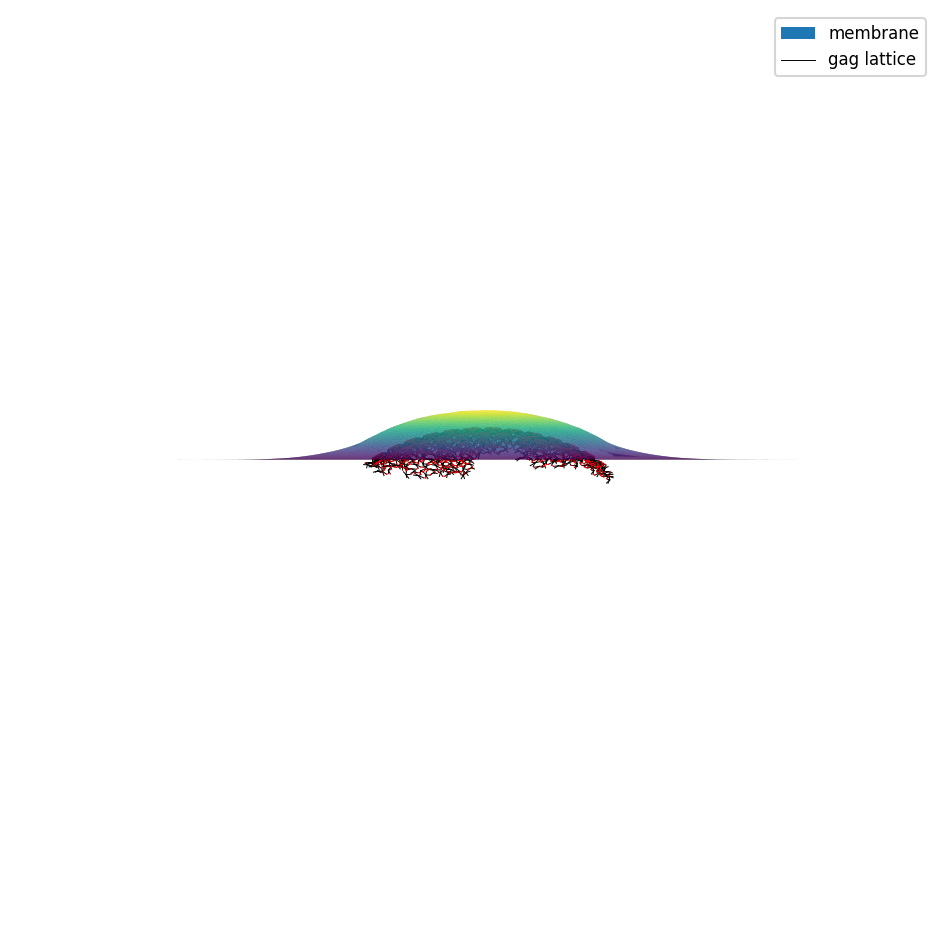

In [12]:
# Plot the surface.

#%
fig = plt.figure(figsize=(24, 12))
ax = plt.axes(projection='3d')

#surf_gags = ax.plot_trisurf(gags["x"], gags["y"], gags["z"], cmap="Oranges")
surf_vertices = ax.plot_trisurf(vertices["x"], vertices["y"], vertices["z"], \
                                cmap="viridis", alpha = 0.7, label = "membrane")
# https://stackoverflow.com/questions/54994600/pyplot-legend-poly3dcollection-object-has-no-attribute-edgecolors2d
surf_vertices._facecolors2d=surf_vertices._facecolors
surf_vertices._edgecolors2d=surf_vertices._edgecolors

#plt.colorbar(surf_vertices, shrink = 0.65, pad = 0.01, anchor = (-0.0, 0.5), label = "height (nm)")


for i in range(0, int(len(df_full_gags)/6)):
    for j in range(1, 6):
        if (i == 0 and j == 1):
            ax.plot([df_full_gags["X"][6 * i], df_full_gags["X"][6 * i + j]],\
                [df_full_gags["Y"][6 * i], df_full_gags["Y"][6 * i + j]],\
                [df_full_gags["Z"][6 * i], df_full_gags["Z"][6 * i + j]], "k", linewidth = 0.7, label = "gag lattice")
        else:
            ax.plot([df_full_gags["X"][6 * i], df_full_gags["X"][6 * i + j]],\
                [df_full_gags["Y"][6 * i], df_full_gags["Y"][6 * i + j]],\
                [df_full_gags["Z"][6 * i], df_full_gags["Z"][6 * i + j]], "k", linewidth = 0.7)
for (i, j) in nearbypt_pairlist:
    ax.plot([df_full_gags_np[i][0], df_full_gags_np[j][0]],\
                [df_full_gags_np[i][1], df_full_gags_np[j][1]],\
                [df_full_gags_np[i][2], df_full_gags_np[j][2]], "r", linewidth = 0.7)
#ax.set_xlabel('X')
#ax.set_ylabel('Y')
#ax.set_zlabel('Z')


ax.set_xlim3d(-90.0, 90.0)
ax.set_ylim3d(-90.0, 90.0)
ax.set_zlim3d(-100.0, 100.0)
ax.set_axis_off()
ax.legend(prop={'size': 12})
ax.view_init(elev = 0, azim = 45)

plt.savefig(num_gags + "gags_membrane_0deg_uniform_scale.png", dpi = 900)

Energy and Force
==

In [13]:
df_ef = pd.read_csv("EnergyForce.csv", index_col = False, header = None, skiprows = 1)
df_ef.columns = ["E_curv", "E_area", "E_reg", "E_total", "F_mean"]
df_ef["E_scaffold"] = df_ef["E_total"] - df_ef["E_curv"] - df_ef["E_area"] - df_ef["E_reg"]
df_ef = df_ef/4.17
df_ef

,E_curv,E_area,E_reg,E_total,F_mean,E_scaffold
0,1515.201439,7.662230e-08,14.258585,243292.565947,0.610988,241763.105923
1,1540.918465,3.130719e-04,260.388489,242649.880096,0.974189,240848.572828
2,1587.146283,2.014156e-03,197.529496,242019.184652,1.260552,240234.506859
3,1637.079137,5.575540e-03,207.524940,241558.752998,1.007048,239714.143345
4,1680.613909,1.030703e-02,276.916067,241151.079137,1.154993,239193.538854
...,...,...,...,...,...,...
4767,2446.666667,1.338904e+03,49.040767,7324.724221,0.104106,3490.112710
4768,2446.666667,1.338899e+03,48.300959,7324.508393,0.041428,3490.641487
4769,2446.666667,1.338885e+03,49.136930,7324.484412,0.108030,3489.795923
4770,2446.666667,1.338880e+03,48.440528,7324.484412,0.062618,3490.497122


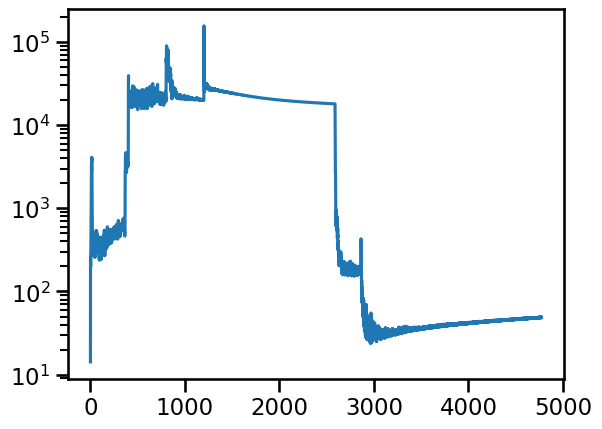

In [14]:
plt.yscale("log")
plt.plot(df_ef["E_reg"])

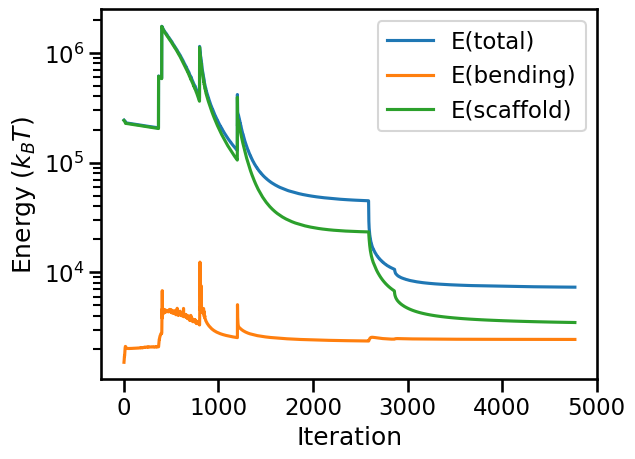

In [15]:
plt.yscale("log")
plt.plot(df_ef["E_total"])
plt.plot(df_ef["E_curv"])
plt.plot(df_ef["E_scaffold"])
plt.xlabel("Iteration")
plt.ylabel("Energy ($k_{B}T$)")
plt.legend(["E(total)", "E(bending)", "E(scaffold)"])
plt.savefig(num_gags + "gags_energyVsIter.png", dpi = 900)

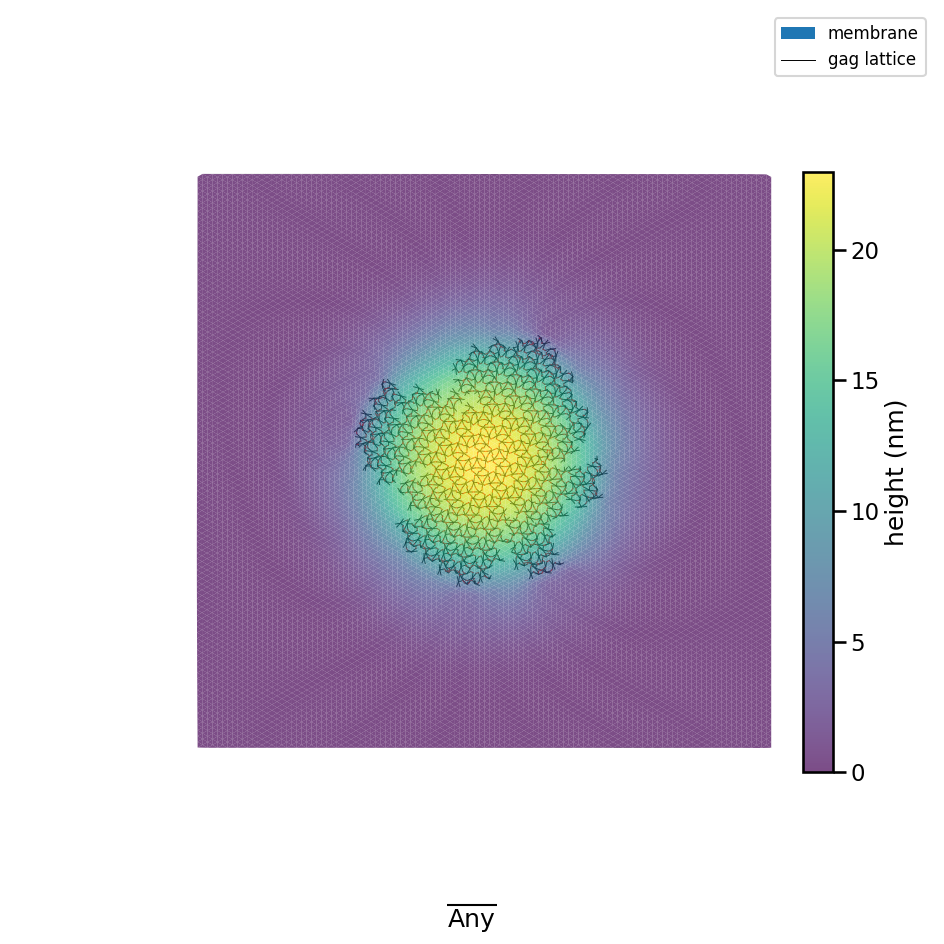

In [28]:
# Plot the surface.
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
#%
fig = plt.figure(figsize=(24, 12))
ax = plt.axes(projection='3d')

#surf_gags = ax.plot_trisurf(gags["x"], gags["y"], gags["z"], cmap="Oranges")
surf_vertices = ax.plot_trisurf(vertices["x"], vertices["y"], vertices["z"], \
                                cmap="viridis", alpha = 0.7, label = "membrane")
# https://stackoverflow.com/questions/54994600/pyplot-legend-poly3dcollection-object-has-no-attribute-edgecolors2d
surf_vertices._facecolors2d=surf_vertices._facecolors
surf_vertices._edgecolors2d=surf_vertices._edgecolors

plt.colorbar(surf_vertices, shrink = 0.65, pad = 0.01, anchor = (-0.6, 0.5), label = "height (nm)")
scalebar = AnchoredSizeBar(ax.transData, 0.01, 'Any', 'lower center', pad = 0.0, color = 'black', frameon = False)
ax.add_artist(scalebar)

for i in range(0, int(len(df_full_gags)/6)):
    for j in range(1, 6):
        if (i == 0 and j == 1):
            ax.plot([df_full_gags["X"][6 * i], df_full_gags["X"][6 * i + j]],\
                [df_full_gags["Y"][6 * i], df_full_gags["Y"][6 * i + j]],\
                [df_full_gags["Z"][6 * i], df_full_gags["Z"][6 * i + j]], "k", linewidth = 0.7, label = "gag lattice")
        else:
            ax.plot([df_full_gags["X"][6 * i], df_full_gags["X"][6 * i + j]],\
                [df_full_gags["Y"][6 * i], df_full_gags["Y"][6 * i + j]],\
                [df_full_gags["Z"][6 * i], df_full_gags["Z"][6 * i + j]], "k", linewidth = 0.7)
for (i, j) in nearbypt_pairlist:
    ax.plot([df_full_gags_np[i][0], df_full_gags_np[j][0]],\
                [df_full_gags_np[i][1], df_full_gags_np[j][1]],\
                [df_full_gags_np[i][2], df_full_gags_np[j][2]], "r", linewidth = 0.7)
#ax.set_xlabel('X')
#ax.set_ylabel('Y')
#ax.set_zlabel('Z')


ax.set_xlim3d(-90.0, 90.0)
ax.set_ylim3d(-90.0, 90.0)
ax.set_zlim3d(-100.0, 100.0)
ax.set_axis_off()
ax.legend(prop={'size': 12})
ax.view_init(elev = 90, azim = 0)

plt.savefig(num_gags + "gags_scalebar_membrane_topdown_uniform_zscale.png", dpi = 900)